# Relocation Analysis Tool


## Introduction and problem Statement

When preparing a relocation to another city, a usual difficulty is to get some visibility on the differents neighbourhood in destination city.
Services already exists to get some insights on what is available in the different neighborhood.

As an international relocation service company, the objective will be to offer a personalised analysis of the neighbourhoods at destination:

    - Based on the current location the customer is living, a neighborhood profile is mapped.
    
    - The different neighborhoods of the destination city will then be mapped:
        - Closest neighborhood, in terms of venues profiles will be identified
        - On top, destination's neighborhoods are grouped in clusters to provide the customer with other suggestions, analysed by comparison to this reference.
        
    - To make the analysis complete, we will also explore the clusterisation focusing on arts & entertainment
    
    
The relocation servie company being working worldwide, the code is made in a generic way, that can be tried from any city to any city.

As part of this notebook, data will illustrate a relocation from Singapore to Toronto, but tool is flexible enough to work worldwide. You can give it a try with any city.


Toronto was chosen for me to evaluate the results of this modified approach (neighbourhood made of a grid instead of defined neighborhood) compared to previous lab, and also because it presented an additional difficulty, being close to the sea. This is taken into account in data treatment.


## Scenario

Scenario of the analysis is the following:
A customer is moving from Singapore to Toronto and is looking for a location in Toronto.
He likes the environmnent he has and first would like to know if there is some neighbourhood with the same overall feeling.
His first search will be based on Toronto Central District, where his company is located. 
The company needs to provide him with some insights on Toronto, in a personalised way, meaning compared to his current neighbourhood.
Company has to:
* Identify the most similar neighbourhood in Toronto
* Provide additional suggestions on similar neighbourhoods
* Provide Additional insights, related to Arts & Entertainment that the customer already mentioned, along as being prepared for other extensive analyses on different aspects (eg. Nightlife).
    Especially, regarding Art & Entertainment, customer is not really satisfied with what the current neighborhood offers and is opened to new suggestions

## Data overview

To reach the business objectives, we will use the following data:

* Current address of customer (manually decided)
* Future area to relocate, defined by it's center and a radius of search.
    * For resource constraints, this area will then be divided in a regular grid of 30 "neighborhoods", the size being adapted to the initial radius defined.

On top, foursquare APIs will be used to capture:
* Recommended venues around the current address of customer in order to get a reference neighboorhood profile
* Recommended venues on the different districts of destination area

## Methodology

The data analysis will be performed as follows:

A - Data Preparation:

- Based on a few manual entries ( Reference/Current negihborhood (address or geocoordinates); Future area to explore (center + radius) )
- The tool will automatically build a grid of neighbourhoods, numbered and located on a map.
- Using foursquare API, the tool will then gather venues around the reference neighbourhood, and future neighborhoods.
Neighbourhoods with too low number of venues (for example, it can correspond to areas off shore) will be filtered out.

B - Closest neighbourhood identification 
- Tool will then evaluate the difference between future and reference neighborhood, in order to proceed to comparison
- Based on this difference result, the 'closest' future neighborhood will be identified.
    - This neighbourhood is located on the map.
    - A comparison summary is provided to the customer.
    
C - Neighbourhood clusterisation
- On top, a clusterisation is done on the neighbourhoods
    - The choice on how to proceed to clusterisation is made either using the elbow method when possible, or through a generic manual selection.
    - This clusterisation allows to identify other possible suggestion to the customers
    - The clusterisation is displayed on the map
    - A comparison profile of the different clusters is also provided to the customer


D - Extended analysis: focus on Art & Entertainment categories
- Additionally, steps B and C are performed again, focusing on Art & Entertainment venues.
    - This provides additional insights on the neighborhood feeling.
    
E - Recommendation
- Based on above studies, a recommendation is provided to the customers, along as possible next steps depending on his feedbacks after this first analysis.

## A - Data preparation

### Manual entries

#### Please define here the current location

In [1]:
current_latitude = 0 
current_longitude = 0

#Or (note that this will overwrite the geocoordinates):

current_address = 'Paya lebar road, singapore' # eg. 'New York, NY'

#### Please define here the future location

In [2]:
future_latitude = 0 
future_longitude = 0

#Or (note that this will overwrite the geocoordinates):

future_address = 'Toronto, ON' # eg. 'Toronto, ON'
future_radius = 10 #Defined in km

#### Please define your foursquare API credentials 

In [3]:
CLIENT_ID = 'Your Client ID' # your Foursquare ID
CLIENT_SECRET = 'Your Client Secret' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

#### Required imports

In [5]:
import pandas as pd
import numpy as np

#uncomment the following if not already installed
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests

#!pip install pyproj
import pyproj
import math

#!pip install folium
import folium

from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans


import matplotlib.cm as cm
import matplotlib.colors as colors



### Grid preparation

This part will focus on defining the grid according to current and future adresses

#### Retrieve geocoordinates

In [6]:
def retrieve_geocoordinates(address):
    address = address.lower().replace(' ','+')
    
    url = "https://nominatim.openstreetmap.org/search?q={}&format=geojson".format(address)
    
    results = requests.get(url).json()
    longitude = results['features'][0]['geometry']['coordinates'][0]
    latitude = results['features'][0]['geometry']['coordinates'][1]
    return latitude, longitude

In [7]:
if len(current_address) > 0:
    current_latitude, current_longitude = retrieve_geocoordinates(current_address)
    
if len(future_address) > 0:
    future_latitude, future_longitude = retrieve_geocoordinates(future_address)

In [8]:
print("Current address geocoordinates:",[current_latitude, current_longitude])
print("Future address geocoordinates:",[future_latitude, future_longitude])

Current address geocoordinates: [1.3230596, 103.8910338]
Future address geocoordinates: [43.653963, -79.387207]


In [9]:
future_geo_center = [future_latitude, future_longitude]

#### Building grids

Based on future address geocoordinates and on radius defined, we build a grid of several uniform squares around this point.

In [10]:
# This part if inspired from example made available on coursera: https://cocl.us/coursera_capstone_notebook
# The code is enhanced to generalize to any place, not only Berlin. https://www.gislounge.com/how-to-calculate-the-boundaries-of-an-utm-zone/
# The code is also modified in order to use the radius defined by the user and adapt the grid according to it, keeping 30 Neighborhoods.

In [11]:
def define_utm_zone(lon):
    zone = math.ceil((lon + 180)/6)
    return zone

def lonlat_to_xy(lon, lat, utm_zone):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=utm_zone, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y, utm_zone):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=utm_zone, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)



print('Coordinate transformation check')
print('-------------------------------')
future_utm_zone = define_utm_zone(future_longitude)
print('Future center longitude={}, latitude={}'.format(future_longitude, future_latitude))
print('Future center utm zone:',future_utm_zone)
x, y = lonlat_to_xy(future_longitude, future_latitude, future_utm_zone)
print('Future center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y, future_utm_zone)
print('Future center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Future center longitude=-79.387207, latitude=43.653963
Future center utm zone: 17
Future center UTM X=630054.2189941956, Y=4834704.153983621
Future center longitude=-79.387207, latitude=43.653963


Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [12]:
future_utm_zone = define_utm_zone(future_longitude)
future_x, future_y = lonlat_to_xy(future_longitude, future_latitude, future_utm_zone) # City center in Cartesian coordinates

grid_radius= future_radius * 6371 / 10
steps=3

radius_search = grid_radius/(2*steps) # Used for search afterward

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = future_x - grid_radius
x_step = grid_radius/steps
y_min = future_y - grid_radius - (int(21/k)*k*grid_radius/steps - 2*grid_radius)/2
y_step = grid_radius/steps * k 

future_latitudes = []
future_longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = grid_radius/(2*steps) if i%2==0 else 0
    
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(future_x, future_y, x, y)
        if (distance_from_center <= grid_radius+1):
            lon, lat = xy_to_lonlat(x, y, future_utm_zone)
            future_latitudes.append(lat)
            future_longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(future_latitudes), 'candidate neighborhood centers generated.')

30 candidate neighborhood centers generated.


Let's make it a proper dataframe:

In [13]:
df_future_neighbourhoods = pd.DataFrame({'Latitude':future_latitudes,'Longitude':future_longitudes})
df_future_neighbourhoods['Neighbourhood'] = range(len(future_latitudes))
df_future_neighbourhoods['Neighbourhood'] = df_future_neighbourhoods['Neighbourhood'].astype(str)
cols_at_beginning = ['Neighbourhood']
df_future_neighbourhoods = df_future_neighbourhoods[[c for c in cols_at_beginning if c in df_future_neighbourhoods] + [c for c in df_future_neighbourhoods if c not in cols_at_beginning]]
df_future_neighbourhoods.head()

,Neighbourhood,Latitude,Longitude
0,0,43.604671,-79.414838
1,1,43.604303,-79.388535
2,2,43.603929,-79.362231
3,3,43.621406,-79.427559
4,4,43.621041,-79.401248


Let's visualize the data we have so far. Future center location and candidate neighborhood centers to see how they are generated:

In [14]:
map_future = folium.Map(location=[future_latitude,future_longitude], zoom_start=13)

folium.Marker([future_latitude,future_longitude], popup=future_address).add_to(map_future)

for name, lat, lon in zip(df_future_neighbourhoods['Neighbourhood'],df_future_neighbourhoods['Latitude'],df_future_neighbourhoods['Longitude']):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_future) 
    folium.Circle([lat, lon], radius=radius_search, color='blue', fill=False).add_to(map_future)
    folium.Marker([lat, lon], popup=name).add_to(map_future)
    
map_future

### Gathering and organising data from foursquare

We will use the following:
- Current neighborhood:
    * No need for a specific dataframe to store it's geospatial coordinates
    * Characteristics will be retrieved in df_current_venues
    * We will create one feature for each category type through onehot encoding
    * We will merge the different venues and apply mean.


- Future neighbourhood:
    * A specific dataframe to store it's geospatial coordinates: **df_future_neighbourhoods**
    * Characteristics will be retrieved in **df_future_venues**
    * We will create one feature for each category type through onehot encoding **df_future_onehot**
    * We will merge the different venues and apply mean. **df_future_grouped**
    * To make visual analysis of the result, we will display, per neighborhood the top venues categories: **df_future_neighborhoods_venues_sorted**. This dataframe is also treated to make sure "no venues" is displayed instead of the category name if the frequency is 0.
    
On top, Neighborhoods with small number of venues will be dropped from the analysis. They can correspond to areas over the sea, and from tests performed, venues returned are actually not properly mapped.


Following function will be used to gather the venues (it automatically adapts to the radius of the grid, which itself adapts to radius of search around the future location point defined by the user)

In [140]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, categories=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Neighbourhood: ',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categories,
            radius_search, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Let's get recommended venues from reference location

In [16]:
current_latitudes = [current_latitude]
current_longitudes = [current_longitude]

df_current_neighbourhoods = pd.DataFrame({'Latitude':current_latitudes,'Longitude':current_longitudes})

In [17]:
df_current_venues = getNearbyVenues("Current Neighbourhood",
                                df_current_neighbourhoods['Latitude'],
                                df_current_neighbourhoods['Longitude'],
                                radius_search
                                  )

Neighbourhood:  C


In [18]:
# one hot encoding
def getOneHot(df):
    df_current_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    df_current_onehot['Neighbourhood'] = df['Neighbourhood'] 

    # move neighborhood column to the first column
    fixed_columns = [df_current_onehot.columns[-1]] + list(df_current_onehot.columns[:-1])
    df_current_onehot = df_current_onehot[fixed_columns]

    return df_current_onehot


In [19]:
df_current_onehot = getOneHot(df_current_venues)
df_current_onehot.head()

,Neighbourhood,Asian Restaurant,BBQ Joint,Basketball Court,Bubble Tea Shop,Burrito Place,Cantonese Restaurant,Chinese Restaurant,Climbing Gym,Dim Sum Restaurant,...,Hotel,Hotpot Restaurant,Indonesian Restaurant,Multiplex,Noodle House,Ramen Restaurant,Snack Place,Soccer Field,Supermarket,Vegetarian / Vegan Restaurant
0,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [20]:
def getGrouped(df_onehot):
    return df_onehot.groupby('Neighbourhood').mean().reset_index()

In [21]:
df_current_grouped = getGrouped(df_current_onehot)
df_current_grouped

,Neighbourhood,Asian Restaurant,BBQ Joint,Basketball Court,Bubble Tea Shop,Burrito Place,Cantonese Restaurant,Chinese Restaurant,Climbing Gym,Dim Sum Restaurant,...,Hotel,Hotpot Restaurant,Indonesian Restaurant,Multiplex,Noodle House,Ramen Restaurant,Snack Place,Soccer Field,Supermarket,Vegetarian / Vegan Restaurant
0,C,0.066667,0.033333,0.033333,0.033333,0.033333,0.033333,0.066667,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.1


#### Let's get future neighborhoods' venues

In [22]:
df_future_venues = getNearbyVenues(df_future_neighbourhoods['Neighbourhood'],
                                df_future_neighbourhoods['Latitude'],
                                df_future_neighbourhoods['Longitude'],
                                radius_search
                                  )

Neighbourhood:  0
Neighbourhood:  1
Neighbourhood:  2
Neighbourhood:  3
Neighbourhood:  4
Neighbourhood:  5
Neighbourhood:  6
Neighbourhood:  7
Neighbourhood:  8
Neighbourhood:  9
Neighbourhood:  10
Neighbourhood:  11
Neighbourhood:  12
Neighbourhood:  13
Neighbourhood:  14
Neighbourhood:  15
Neighbourhood:  16
Neighbourhood:  17
Neighbourhood:  18
Neighbourhood:  19
Neighbourhood:  20
Neighbourhood:  21
Neighbourhood:  22
Neighbourhood:  23
Neighbourhood:  24
Neighbourhood:  25
Neighbourhood:  26
Neighbourhood:  27
Neighbourhood:  28
Neighbourhood:  29


In [23]:
df_future_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,43.604671,-79.414838,Song Cook Corean Chili,43.604021,-79.416823,Korean Restaurant
1,0,43.604671,-79.414838,Timothy's World Coffee,43.598230,-79.416521,Coffee Shop
2,1,43.604303,-79.388535,Fabio's Menswear,43.612217,-79.392700,Clothing Store
3,1,43.604303,-79.388535,Gibraltar Point Darkroom,43.613170,-79.383993,Art Gallery
4,3,43.621406,-79.427559,Ontario Place Cinesphere IMAX,43.627817,-79.418023,Movie Theater
...,...,...,...,...,...,...,...
675,29,43.703247,-79.359529,Bikram Yoga East York,43.705450,-79.351448,Yoga Studio
676,29,43.703247,-79.359529,Kintako Japanese Restaurant,43.711597,-79.363962,Sushi Restaurant
677,29,43.703247,-79.359529,Iqbal foods,43.705751,-79.352054,Grocery Store
678,29,43.703247,-79.359529,Amsterdam Barrel House,43.706021,-79.361329,Brewery


In [24]:
def getCount(df):
    return df.groupby('Neighbourhood').count()

In [25]:
df_future_venues_count = getCount(df_future_venues)
df_future_venues_count

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
0,2,2,2,2,2,2
1,2,2,2,2,2,2
10,26,26,26,26,26,26
11,8,8,8,8,8,8
12,30,30,30,30,30,30
13,30,30,30,30,30,30
14,30,30,30,30,30,30
15,30,30,30,30,30,30
16,30,30,30,30,30,30


#### Data treatment

We first drop neighborhoods with low number of venues, that correspond to areas off shore, and venues seem to be incorrectly mapped to those.

In [26]:
def dropEmptyNeighbourhoods(df):
    too_empty_neighbourhoods = getCount(df)[ df_future_venues_count['Venue'] < 10] 
    df_filter = df[ df['Neighbourhood'].isin(too_empty_neighbourhoods.index.tolist()) ]  
    df.drop(df_filter.index, inplace=True)
    return df

In [27]:
#too_empty_neighbourhoods = df_future_venues_count[ df_future_venues_count['Venue'] < 10] 
#df_filter = df_future_venues[ df_future_venues['Neighbourhood'].isin(too_empty_neighbourhoods.index.tolist()) ]  
#df_future_venues.drop(df_filter.index, inplace=True)
df_future_venues = dropEmptyNeighbourhoods(df_future_venues)
df_future_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
16,5,43.62067,-79.374937,Toronto Islands,43.622112,-79.378495,Park
17,5,43.62067,-79.374937,Centreville Amusement Park,43.620370,-79.373792,Theme Park
18,5,43.62067,-79.374937,Centre Island Beach,43.616474,-79.373320,Beach
19,5,43.62067,-79.374937,Toronto Islands Pier,43.615707,-79.371260,Scenic Lookout
20,5,43.62067,-79.374937,Far Enough Farm,43.619853,-79.371797,Farm


We then gather data from the different neighborhoods and format them in an intelligible way.

In [28]:
df_future_onehot = getOneHot(df_future_venues)

df_future_onehot.head(10)

,Neighbourhood,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
16,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
df_future_grouped = getGrouped(df_future_onehot)
df_future_grouped

,Neighbourhood,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,13,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333
3,14,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.033333,0.000000,0.066667,0.000000,0.000000,0.033333,0.000000,0.000000
4,15,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,16,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000
6,17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,18,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,19,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,...,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000


#### Let's modify the dataframe to make a comparative analysis

This step does not affect the clustering itself, but will help interpreting the results as a comparison with current neighborhood.

First, the columns may not be the same, let's compare the lists; make them uniform while adding 0 to the initially missing columns

In [30]:
def alignColumns(df_current, df_future):
    list_future_columns = df_future.columns.values.tolist()
    list_current_columns = df_current.columns.values.tolist()
    
    in_future_not_in_current = list(set(list_future_columns) - set(list_current_columns))
    in_current_not_in_future = list(set(list_current_columns) - set(list_future_columns))
    
    for s in in_current_not_in_future:
        df_future[s] = 0.0

    for s in in_future_not_in_current:
        df_current[s] = 0.0
    
    return df_current, df_future

In [31]:
df_current_grouped, df_future_grouped = alignColumns(df_current_grouped, df_future_grouped)

In [32]:
df_current_grouped.shape

(1, 187)

In [33]:
df_future_grouped.shape

(23, 187)

Now let's make the difference between both

In [34]:
def futureCurrentDiff(df_current_group, df_future_group):
    list_future_columns = df_future_group.columns.values.tolist()
    list_future_columns.remove('Neighbourhood')
    for s in list_future_columns:
        df_future_group[s] = df_future_group[s] - df_current_group[s].loc[0]
        
    return df_future_group

In [35]:
df_future_grouped = futureCurrentDiff(df_current_grouped, df_future_grouped)
df_future_grouped

,Neighbourhood,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Filipino Restaurant,Bubble Tea Shop,Food Court,Dim Sum Restaurant,Soccer Field,Hotpot Restaurant,Basketball Court,Chinese Restaurant,Multiplex,Noodle House
0,10,0.000000,0.000000,0.000000,0.000000,-0.066667,0.000000,-0.033333,0.000000,0.000000,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
1,12,0.000000,0.000000,0.000000,0.000000,-0.066667,0.000000,0.000000,0.000000,0.033333,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
2,13,0.000000,0.000000,0.000000,0.000000,-0.033333,0.000000,-0.033333,0.000000,0.033333,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
3,14,0.000000,0.000000,0.000000,0.033333,-0.066667,0.000000,-0.033333,0.000000,0.066667,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
4,15,0.033333,0.000000,0.000000,0.000000,-0.066667,0.000000,0.000000,0.000000,0.000000,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
5,16,0.000000,0.000000,0.000000,0.000000,-0.066667,0.033333,-0.033333,0.000000,0.033333,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
6,17,0.000000,0.000000,0.000000,0.000000,-0.066667,0.000000,-0.033333,0.000000,0.000000,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
7,18,0.000000,0.000000,0.033333,0.000000,-0.066667,0.000000,-0.033333,0.000000,0.066667,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
8,19,0.000000,0.000000,0.000000,0.033333,-0.066667,0.000000,-0.033333,0.000000,0.033333,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333
9,20,0.000000,0.000000,0.000000,0.000000,-0.066667,0.000000,-0.033333,0.000000,0.000000,...,-0.033333,-0.033333,-0.1,-0.033333,-0.033333,-0.033333,-0.033333,-0.066667,-0.033333,-0.033333


## B- Finding the closest neighborhood

Now that the dataframe is defined as a difference of frequency of different venues categories, the "closest" neighbourhood is the neighbourhood with lowest values. 

We use the least square estimation.

In [38]:
list_future_columns = df_future_grouped.columns.values.tolist()
list_future_columns.remove('Neighbourhood')

df_future_distance = np.square(df_future_grouped[list_future_columns])
df_future_distance = pd.DataFrame(df_future_distance.sum(axis=1))
df_future_distance.rename(columns={ df_future_distance.columns[0]:'Score'}, inplace=True)
df_future_distance['Neighbourhood'] = df_future_grouped['Neighbourhood']
df_future_distance.head()

,Score,Neighbourhood
0,0.130993,10
1,0.106667,12
2,0.093333,13
3,0.095556,14
4,0.104444,15


In [39]:
#Selecting the row with minimum value
neighbourhood_min = df_future_distance.loc[df_future_distance['Score'].idxmin()]
type(neighbourhood_min)
print('Closest neighbourhood is the neighbourhood: {} with a score of {}'.format(neighbourhood_min['Neighbourhood'], neighbourhood_min['Score']))

Closest neighbourhood is the neighbourhood: 20 with a score of 0.08000000000000002


#### Let's locate the 'closest' neighbourhood

For further usage, let's define the corresponding function, and on top we will associate geospatial data:

In [40]:
def getClosest(df_current_group, df_future_group, df_future_neighb):
    
    list_future_columns = df_future_group.columns.values.tolist()
    list_future_columns.remove('Neighbourhood')
    
    df_future_distance = np.square(df_future_group[list_future_columns])
    df_future_distance = pd.DataFrame(df_future_distance.sum(axis=1))
    df_future_distance.rename(columns={ df_future_distance.columns[0]:'Score'}, inplace=True)
    df_future_distance['Neighbourhood'] = df_future_group['Neighbourhood']
    
  #Selecting the row with minimum value
    neighbourhood_min = df_future_distance.loc[df_future_distance['Score'].idxmin()]

    df_future_closest = df_future_neighb
    df_future_closest = df_future_closest.loc[df_future_closest['Neighbourhood'] == neighbourhood_min['Neighbourhood'] ]

    return df_future_closest, neighbourhood_min

In [41]:
df_future_closest, neighbourhood_min = getClosest(df_current_grouped, df_future_grouped, df_future_neighbourhoods)
df_future_closest

,Neighbourhood,Latitude,Longitude
20,20,43.670516,-79.386764


In [42]:
def mapClosest(future_geo, df_future_close):
    map_future_closest = folium.Map(location=future_geo, zoom_start=13)

    folium.Marker(future_geo, popup=future_address).add_to(map_future_closest)

    for name, lat, lon in zip(df_future_close['Neighbourhood'],df_future_close['Latitude'],df_future_close['Longitude']):
        folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_future_closest) 
        folium.Circle([lat, lon], radius=radius_search, color='blue', fill=True).add_to(map_future_closest)
        folium.Marker([lat, lon], popup=name).add_to(map_future_closest)

    title_html = '''
             <h3 align="center" style="font-size:20px"><b>Closest neighbourhood localisation</b></h3>
             '''
    map_future_closest.get_root().html.add_child(folium.Element(title_html))
        
    
    return map_future_closest

In [43]:
map_future_closest = mapClosest(future_geo_center, df_future_closest)
map_future_closest

Let's analyse a bit further this closest neighborhood. We will see what kind of venues were not existing in the current neighbourhood, and vice-versa

In [44]:
def getClosestSummary(df_future_group, neighbourhood_min):
    closest_stats = df_future_group.loc[ df_future_group['Neighbourhood'] == neighbourhood_min['Neighbourhood'] ]
    closest_stats = closest_stats.drop(['Neighbourhood'], axis=1)
    closest_stats = closest_stats.mean().sort_values(ascending = False) #Using mean here to get a series of values by venues categories; but as there is only one line it is similar.
    closest_summary = pd.concat([closest_stats.head(10), closest_stats.tail(10)])
    
    return closest_summary

In [45]:
closest_summary = getClosestSummary(df_future_grouped, neighbourhood_min)

In [95]:
def plotSummary(close_summary, title):
    close_summary.plot(kind='barh', figsize=(10,10)).invert_yaxis()
    plt.title(title)
    plt.xlabel('Frequency comparison with current neighbourhood')

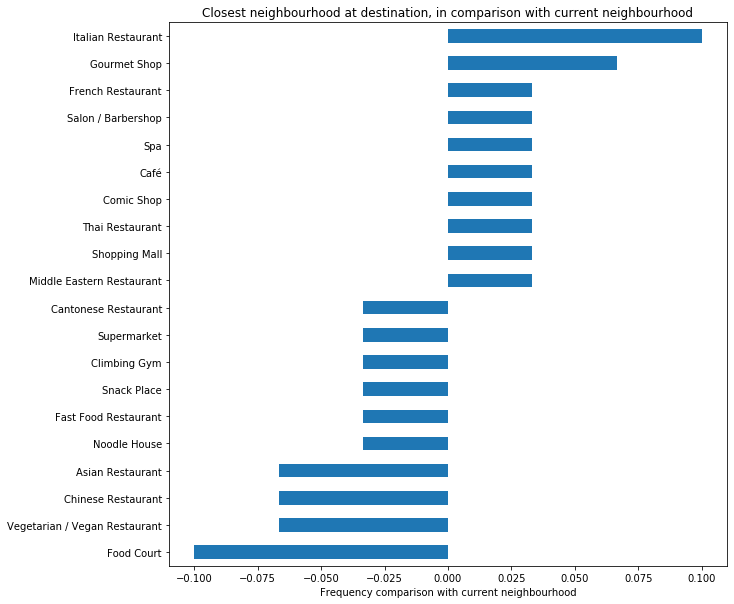

In [47]:
plotSummary(closest_summary, 'Closest neighbourhood at destination, in comparison with current neighbourhood')

Closest neighbourhood found in toronto is different from initial location in Singapore:

The main difference is about the food places available: Less food court and less asian food (except thai), which is not a big surprise; 
and more italian restaurants and gourmet shops. 

## C - Clusterisation of destination neighbourhoods

Previous part focused on the closest neighbourhood. 
On top, we need to provide the customer with suggestions on other neighbourhood flavours.
To do so, we proceed to a clusterisation of destination's neighbourhood still compared to initial neighbourhood

#### For curiosity: print each neighborhood along with the top 5 most common venues

#### Let's use *pandas* dataframe that will allow visual checks

First, let's write a function to sort the venues in descending order.

To make it cleaner, we also change the displayed values when there actually is no venues (for example: all venues are of same category, then 2nd -> 10th categories will display 'No venues'

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    for indexi in np.arange(row_categories_sorted.shape[0]):
        if row_categories_sorted.iloc[indexi] == 0.0:
            row_categories_sorted.index.values[indexi] = 'No venues'
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [49]:
def getNeighbourhoodsVenuesSorted(df_future_group, num_top_venues):
    
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    columns = ['Neighbourhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_future_neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
    df_future_neighbourhoods_venues_sorted['Neighbourhood'] = df_future_group['Neighbourhood']

    for ind in np.arange(df_future_grouped.shape[0]):
        df_future_neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_future_group.iloc[ind, :], num_top_venues)

    return df_future_neighbourhoods_venues_sorted

In [50]:
num_top_venues = 10

df_future_neighbourhoods_venues_sorted = getNeighbourhoodsVenuesSorted(df_future_grouped, num_top_venues)
df_future_neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10,Beach,Harbor / Marina,Boat or Ferry,Park,Coffee Shop,Theater,Café,Racetrack,Clothing Store,Soccer Stadium
1,12,Restaurant,Bar,Coffee Shop,Pizza Place,Brewery,Café,Sushi Restaurant,Sports Bar,Other Great Outdoors,Clothing Store
2,13,Italian Restaurant,Restaurant,Health Food Store,Boutique,Breakfast Spot,Mexican Restaurant,Thai Restaurant,Café,Candy Store,Tapas Restaurant
3,14,Café,Mexican Restaurant,Vietnamese Restaurant,Bakery,Burger Joint,Gourmet Shop,Organic Grocery,Caribbean Restaurant,Cocktail Bar,Doner Restaurant
4,15,Café,Coffee Shop,Theater,Italian Restaurant,Restaurant,American Restaurant,Middle Eastern Restaurant,Farmers Market,Japanese Restaurant,Clothing Store


<a id='item4'></a>

### Clustering Neighborhoods

#### Let's try to find the optimum K-mean

Even if uncertain, a possibility to try and determine the optimum k-mean is to implement the elbow method. This requires to calculate the distorsion, and to plot it depending on k.

In [51]:
def elbowDetermination(df_future_group):
    df_future_grouped_clustering = df_future_group.drop('Neighbourhood', 1)

    # k means determine k
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(df_future_grouped_clustering)
        kmeanModel.fit(df_future_grouped_clustering)
        distortions.append(sum(np.min(cdist(df_future_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_future_grouped_clustering.shape[0])

    # Plot the elbow
    plt.plot()
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

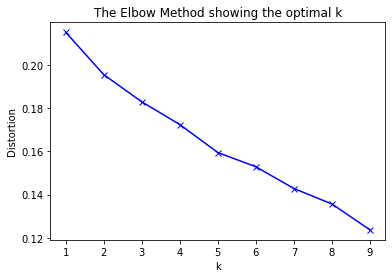

In [52]:
elbowDetermination(df_future_grouped)

Elbow Methodology unfortunately does not provide great results on our example.

#### Manual selection of k and random_state

To get some reproducible result, we will therefore proceed to manual selection, specifying both a number of cluster (between 2 and 7) and different random_states.

In [53]:
def manualKdetermination(df_future_group):
    df_future_grouped_clustering = df_future_group.drop('Neighbourhood', 1)

    for k in range(3,8):
        for i in range(4):
            kclusters = k

            kmeans = KMeans(n_clusters=kclusters, random_state=i).fit(df_future_grouped_clustering)
            Cluster_labels = pd.DataFrame()
            Cluster_labels.insert(0, 'Cluster Labels', kmeans.labels_)

            df_future_neighbourhoods_venues_sorted['Cluster Labels'] = Cluster_labels['Cluster Labels']

            df_future_merged = df_future_neighbourhoods

            # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
            df_future_merged = df_future_merged.join(df_future_neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
            df_future_merged.dropna(subset=['Cluster Labels'], axis=0, inplace = True)
            df_future_merged['Cluster Labels'] = df_future_merged['Cluster Labels'].astype(int)

            df_future_merged_grouped = df_future_merged[['Cluster Labels','Neighbourhood']].groupby(['Cluster Labels']).count()
            print('With',k,'labels and random_state = ',i,':')
            display(df_future_merged_grouped)

In [54]:
manualKdetermination(df_future_grouped)

With 3 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,19
1,1
2,3


With 3 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,19
1,3
2,1


With 3 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,9
1,1
2,13


With 3 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,10
1,12
2,1


With 4 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,19
1,1
2,2
3,1


With 4 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,1
1,8
2,11
3,3


With 4 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,7
1,12
2,1
3,3


With 4 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,1
1,19
2,1
3,2


With 5 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,11
1,1
2,2
3,1
4,8


With 5 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,10
1,2
2,1
3,1
4,9


With 5 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,1
1,11
2,1
3,2
4,8


With 5 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,7
1,3
2,1
3,11
4,1


With 6 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,1
1,5
2,9
3,1
4,2
5,5


With 6 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,1
1,11
2,2
3,1
4,1
5,7


With 6 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,2
1,5
2,9
3,1
4,5
5,1


With 6 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,6
1,9
2,1
3,2
4,1
5,4


With 7 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,7
1,1
2,2
3,1
4,7
5,4
6,1


With 7 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,2
1,3
2,1
3,6
4,2
5,8
6,1


With 7 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,1
1,5
2,5
3,1
4,1
5,8
6,2


With 7 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,8
1,3
2,1
3,1
4,4
5,4
6,2


As expected, results are really different depending on k, but also on random state. 
Howeverm it seems that there are mainly 2 big clusters, even if 6 clusters suggest a possible distribution of 3 clusters with reasonable sizes

Let's see what this offers with k=3 and random_state = 2; to see what are the 2 main clusters

In [55]:
# set number of clusters
kclusters = 3
state = 2

In [56]:
def getClusters(df_future_group, k, rdm_state):
    df_future_grouped_clustering = df_future_group.drop('Neighbourhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=state).fit(df_future_grouped_clustering)
    Cluster_labels = pd.DataFrame()
    Cluster_labels.insert(0, 'Cluster Labels', kmeans.labels_)
    
    return Cluster_labels

In [57]:
Cluster_labels = getClusters(df_future_grouped, kclusters, state)
Cluster_labels.head()

,Cluster Labels
0,0
1,0
2,2
3,2
4,2


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [58]:
def getMerged(df_future_neighbourhoods_venues_sorted, Cluster_labels):
    df_future_neighbourhoods_venues_sorted['Cluster Labels'] = Cluster_labels['Cluster Labels']

    df_future_merged = df_future_neighbourhoods

    # merge the table to add latitude/longitude for each neighborhood
    df_future_merged = df_future_merged.join(df_future_neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
    df_future_merged.dropna(subset=['Cluster Labels'], axis=0, inplace = True)
    df_future_merged['Cluster Labels'] = df_future_merged['Cluster Labels'].astype(int)
    return df_future_merged

In [59]:
df_future_merged = getMerged(df_future_neighbourhoods_venues_sorted, Cluster_labels)
df_future_merged.head()

,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
5,5,43.620670,-79.374937,Harbor / Marina,Theme Park,Park,Beach,Pizza Place,Burger Joint,Scenic Lookout,Playground,Pier,Farm,0
7,7,43.638140,-79.440287,Tibetan Restaurant,Indian Restaurant,Bakery,Flower Shop,Thrift / Vintage Store,Café,Tea Room,Tattoo Parlor,French Restaurant,American Restaurant,2
8,8,43.637778,-79.413968,Coffee Shop,Furniture / Home Store,Theme Park,Café,Hockey Arena,Seafood Restaurant,Soccer Stadium,Comfort Food Restaurant,Dessert Shop,Park,0
9,9,43.637410,-79.387650,Scenic Lookout,Aquarium,Coffee Shop,Park,Brewery,Gym,Baseball Stadium,Monument / Landmark,Neighborhood,Café,0
10,10,43.637035,-79.361332,Beach,Harbor / Marina,Boat or Ferry,Park,Coffee Shop,Theater,Café,Racetrack,Clothing Store,Soccer Stadium,0


Finally, let's visualize the resulting clusters

In [60]:
def ClusterMap(future_geo_center, df_future_merge, kclusters):
    
    map_clusters = folium.Map(location=future_geo_center, zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_future_merge['Latitude'], df_future_merge['Longitude'], df_future_merge['Neighbourhood'], df_future_merge['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.Circle([lat, lon], radius=radius_search, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1]).add_to(map_clusters)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
        
    title_html = '''
             <h3 align="center" style="font-size:20px"><b>Clusters at destination</b></h3>
             '''
    map_clusters.get_root().html.add_child(folium.Element(title_html))

    return map_clusters

In [61]:
map_clusters = ClusterMap(future_geo_center, df_future_merged, kclusters)
map_clusters

<a id='item5'></a>

### Examine clusters

Note that in our example, closest neighbourhood (20) is in cluster 2.
We will retrieve here the different clusters and do some analysis of their main characteristics, always in comparison with initial cluster.

Visualisation on the map seem to indicate a difference between city center and areas close to the sea and harbor, let's get some addtional details.

In [96]:
def getClusterSummary(df_future_merge, df_future_group, num_cluster):
    neighbourhoods_cluster = df_future_merge.loc[df_future_merge['Cluster Labels'] == num_cluster]['Neighbourhood'].tolist()
    cluster_stats = df_future_group[df_future_group['Neighbourhood'].isin(neighbourhoods_cluster)]
    cluster_stats = cluster_stats.drop(['Neighbourhood'], axis=1)
    cluster_ordered = cluster_stats.mean().sort_values(ascending = False)
    cluster_summary = pd.concat([cluster_ordered.head(10), cluster_ordered.tail(10)])
    return cluster_summary

In [99]:
summary_0 = getClusterSummary(df_future_merged, df_future_grouped, 0)
summary_1 = getClusterSummary(df_future_merged, df_future_grouped, 1)
summary_2 = getClusterSummary(df_future_merged, df_future_grouped, 2)

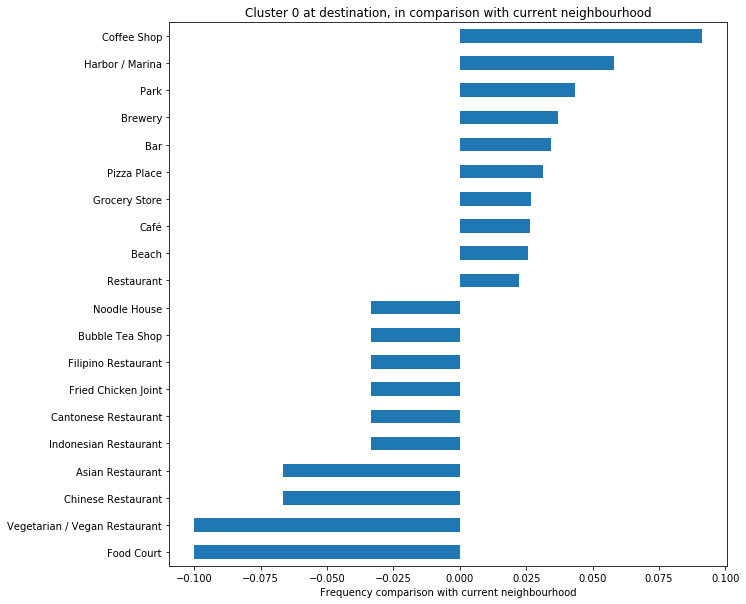

In [100]:
plotSummary(summary_0, 'Cluster 0 at destination, in comparison with current neighbourhood')

As expected, Cluster 0 have more harbor venues. (The neighbourhood chosen in singapore is not close to the sea).
Cluster 0 will lack food and asian food compared to current neighbourhood. 
However, it will present much more coffee shops, café, bars, park and harbor venues + Beach. 

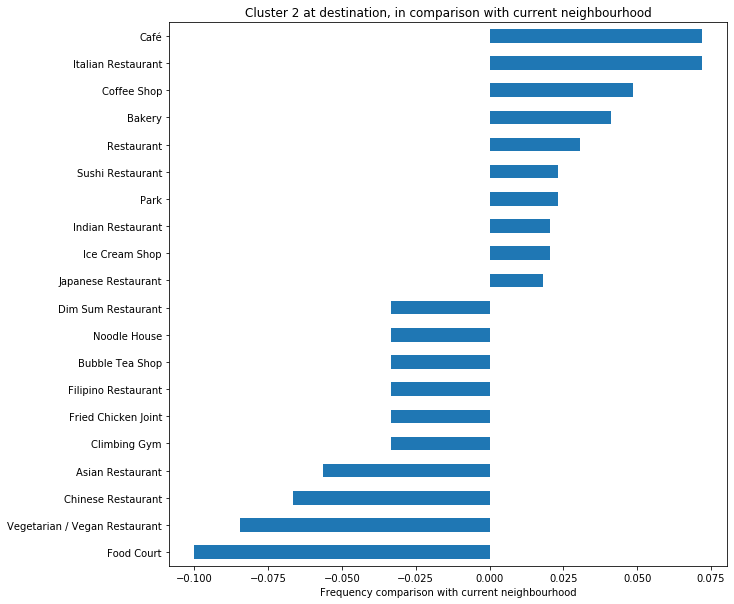

In [101]:
plotSummary(summary_2, 'Cluster 2 at destination, in comparison with current neighbourhood')

This cluster, which include the closest cluster does no miracle regarding most of asian foods. 
However, thai and indiant restaurants will be in average more present than current neighbourhood in singapore (neighbourhood is mainly chinese and malay by the way, for your information)
This neighbourhood will on top present more Café and Italian Restaurants.

## D - Extended analyses - by category

This overview provided good insights, mainly on food places profile. 

To complete the analysis, we can drive the comparison, by selecting only specific types of venues.
Foursquare offers different main categories such as Art & Entertainment, Food, and Nightlife.

Now that all tools are in place and corresponding functions defined, doing these additional analyses is much faster, after we do a little tirck regarding the categories.

As per scenario, we will focus here on the Art & Entertainment aspect.

### Foursquare "Art & Entertainment" categories

Unfortunately, Art &entertainment, Food and other 'Major' categories share the same category Id in foursquare (not sure if normal)
In order to refine the search, we therefore need to gather the list of sub categories for each.

In [102]:
url='https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION)
results = requests.get(url).json()

Mapping between json and categories:
0 = Art&Entertainment
1 = College & University
2 = Event
3 = Food 
4 = Nightlife Spot
5 = 

For the purpose of this report, we illustrate the methodology based on art.


In [103]:
category_code = 0 

In [112]:
list_art_subcategories = []

for i in range(len(results['response']['categories'][category_code]['categories'])): # Analysis of the json file indicates that results['response']['categories'][0] corresponds to the Art&Entertainment Category)
    list_art_subcategories.append(results['response']['categories'][category_code]['categories'][i]['id'])
    
list_art_subcategories = ','.join(list_art_subcategories)
list_art_subcategories

'56aa371be4b08b9a8d5734db,4fceea171983d5d06c3e9823,4bf58dd8d48988d1e1931735,4bf58dd8d48988d1e2931735,4bf58dd8d48988d1e4931735,4bf58dd8d48988d17c941735,52e81612bcbc57f1066b79e7,4bf58dd8d48988d18e941735,5032792091d4c4b30a586d5c,52e81612bcbc57f1066b79ef,52e81612bcbc57f1066b79e8,56aa371be4b08b9a8d573532,4bf58dd8d48988d1f1931735,52e81612bcbc57f1066b79ea,4deefb944765f83613cdba6e,5744ccdfe4b0c0459246b4bb,52e81612bcbc57f1066b79e6,5642206c498e4bfca532186c,52e81612bcbc57f1066b79eb,4bf58dd8d48988d17f941735,4bf58dd8d48988d181941735,4bf58dd8d48988d1e5931735,5744ccdfe4b0c0459246b4b8,4bf58dd8d48988d1f2931735,4bf58dd8d48988d1e3931735,507c8c4091d498d9fc8c67a9,56aa371be4b08b9a8d573514,4bf58dd8d48988d1f4931735,52e81612bcbc57f1066b79e9,52e81612bcbc57f1066b79ec,56aa371be4b08b9a8d5734f9,4bf58dd8d48988d184941735,4bf58dd8d48988d182941735,56aa371be4b08b9a8d573520,4bf58dd8d48988d193941735,4bf58dd8d48988d17b941735'

#### Function definition

In [113]:
def getVenues(df_current_neighbourhood,df_future_neighbourhoods,list_categories):
        #Current Neighbourhood
    df_current_venues_e = getNearbyVenues("Current Neighbourhood",
                                df_current_neighbourhoods['Latitude'],
                                df_current_neighbourhoods['Longitude'],
                                radius_search,
                                list_categories
                                           )
    
    #Future Neighbourhood
    df_future_venues_e = getNearbyVenues(df_future_neighbourhoods['Neighbourhood'],
                                df_future_neighbourhoods['Latitude'],
                                df_future_neighbourhoods['Longitude'],
                                radius_search,
                                list_categories
                                  )
    df_future_venues_e = dropEmptyNeighbourhoods(df_future_venues_e)
    
    return df_current_venues_e, df_future_venues_e

In [125]:
def determineClosestNeighbourhood(df_current_venues,df_future_venues, df_future_neighbourhoods=df_future_neighbourhoods):
    #Current Neighbourhood
    df_current_onehot_e = getOneHot(df_current_venues)
    df_current_grouped_e = getGrouped(df_current_onehot_e)
    
    df_future_onehot_e = getOneHot(df_future_venues)
    df_future_grouped_e = getGrouped(df_future_onehot_e)
    df_current_grouped_e, df_future_grouped_e = alignColumns(df_current_grouped_e, df_future_grouped_e)
    df_future_grouped_e = futureCurrentDiff(df_current_grouped_e, df_future_grouped_e)
    df_future_closest_e, neighbourhood_min_e = getClosest(df_current_grouped_e, df_future_grouped_e, df_future_neighbourhoods)
    
    map_future_closest_e = mapClosest(future_geo_center, df_future_closest_e)
   
    closest_summary_e = getClosestSummary(df_future_grouped_e, neighbourhood_min_e)

    
    return df_future_grouped_e, df_future_closest_e, map_future_closest_e, closest_summary_e

#### Closest neighbourhood (in terms of art)

In [ ]:
df_current_venues_art, df_future_venues_art = getVenues(df_current_neighbourhoods,df_future_neighbourhoods,list_art_subcategories)

Note: If a warning is displayed, it is not an error.
However if service is unstable, you may face the "Key 'groups' " error. Please retry, the error appears from time to time; not always at the same cluster, this is a service unstability rather than an actual error.

In [126]:
df_future_grouped_art, df_future_closest_art, map_future_closest_art, closest_summary_art = determineClosestNeighbourhood(df_current_venues_art, df_future_venues_art)

In [127]:
map_future_closest_art

Cluster 15 is the closest to current neighbourhood, in terms of arts and entertainment.
However, the current neighbourhood is not really satisfactory according to customer; let's get more details about it, and then let's see what other profiles are available in toronto.

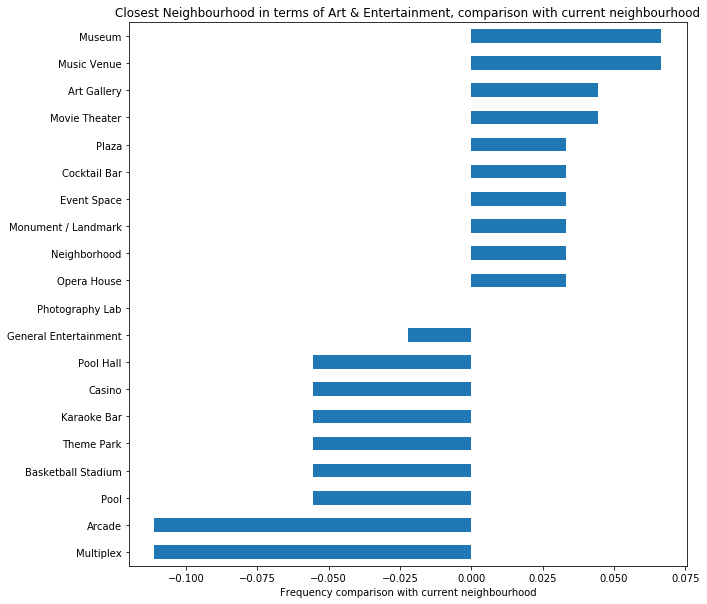

In [128]:
plotSummary(closest_summary_art, 'Closest Neighbourhood in terms of Art & Entertainment, comparison with current neighbourhood')

Conclusion: We can expect a neighbourhood with slightly less entertainment venues, but more art/museum centered than currently.

### Clusterisation according to art and entertainment

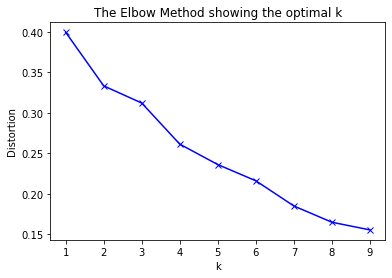

In [129]:
elbowDetermination(df_future_grouped_art)

Here again, no obvious elbow, we will proceed to manual selection

In [130]:
manualKdetermination(df_future_grouped_art)

With 3 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,20
1,2
2,1


With 3 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,20
1,2
2,1


With 3 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,20
1,2
2,1


With 3 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,20
1,2
2,1


With 4 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,2
1,18
2,2
3,1


With 4 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,3
1,1
2,17
3,2


With 4 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,3
1,2
2,1
3,17


With 4 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,2
1,18
2,2
3,1


With 5 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,15
1,3
2,2
3,1
4,2


With 5 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,16
1,2
2,1
3,3
4,1


With 5 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,16
1,2
2,3
3,1
4,1


With 5 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,5
1,12
2,2
3,1
4,3


With 6 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,2
1,15
2,1
3,1
4,3
5,1


With 6 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,15
1,2
2,1
3,3
4,1
5,1


With 6 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,15
1,2
2,3
3,1
4,1
5,1


With 6 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,1
1,15
2,2
3,1
4,3
5,1


With 7 labels and random_state =  0 :


,Neighbourhood
Cluster Labels,
0,3
1,12
2,2
3,1
4,1
5,3
6,1


With 7 labels and random_state =  1 :


,Neighbourhood
Cluster Labels,
0,5
1,10
2,2
3,1
4,3
5,1
6,1


With 7 labels and random_state =  2 :


,Neighbourhood
Cluster Labels,
0,12
1,2
2,1
3,1
4,3
5,3
6,1


With 7 labels and random_state =  3 :


,Neighbourhood
Cluster Labels,
0,11
1,2
2,1
3,4
4,3
5,1
6,1


Based on above, it appears that most neighbourhood are clustered in the same cluster, with some additional alternatives around.

We Select k and random state:

In [131]:
kclusters = 4
state = 1

In [132]:
Cluster_labels = getClusters(df_future_grouped_art, kclusters, state)
df_future_merged_art = getMerged(df_future_neighbourhoods_venues_sorted, Cluster_labels)

In [133]:
map_clusters_art = ClusterMap(future_geo_center, df_future_merged_art, kclusters)
map_clusters_art

We can notice that both the Cluster 15, identified as the closest in terms of art, and cluster 20, previously identified as the closest overall are in Cluster 2.
Good news is that both these neighborhoods are at walking distance from Cluster 0; so let's get some details on these 2 especially to see what to expect.

In [135]:
summary_0_art = getClusterSummary(df_future_merged_art, df_future_grouped_art, 0)
summary_1_art = getClusterSummary(df_future_merged_art, df_future_grouped_art, 1)
summary_2_art = getClusterSummary(df_future_merged_art, df_future_grouped_art, 2)
summary_3_art = getClusterSummary(df_future_merged_art, df_future_grouped_art, 3)

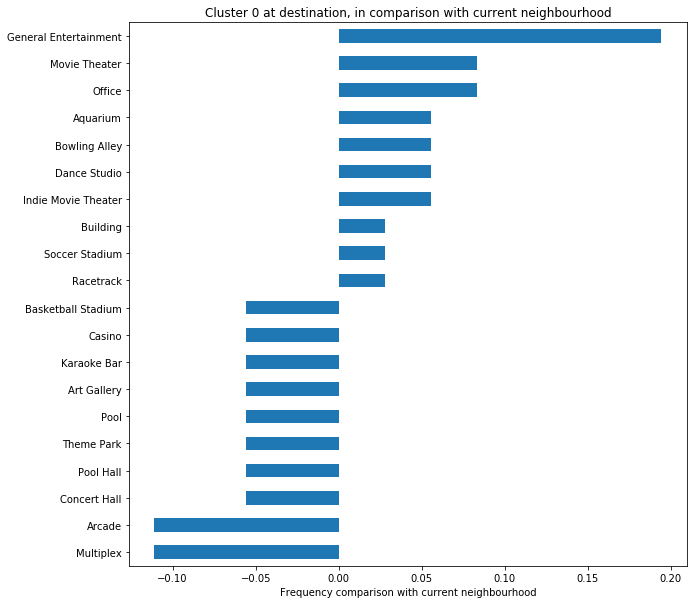

In [136]:
plotSummary(summary_0_art, 'Cluster 0 at destination, in comparison with current neighbourhood')

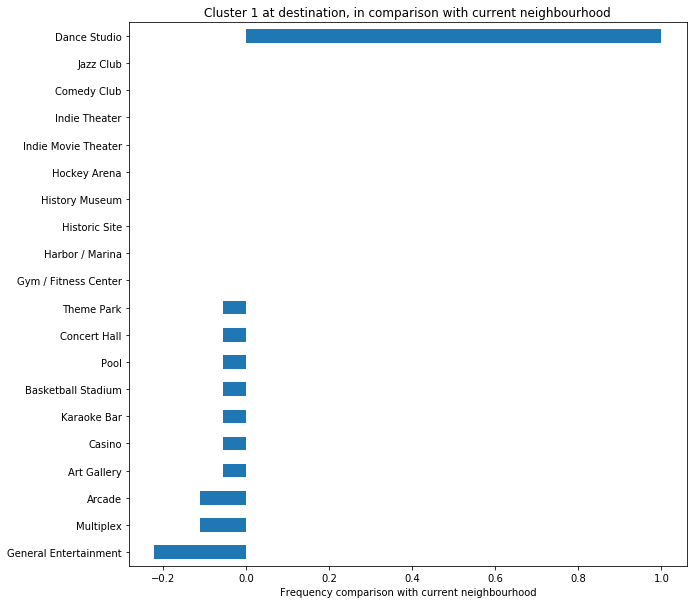

In [137]:
plotSummary(summary_1_art, 'Cluster 1 at destination, in comparison with current neighbourhood')

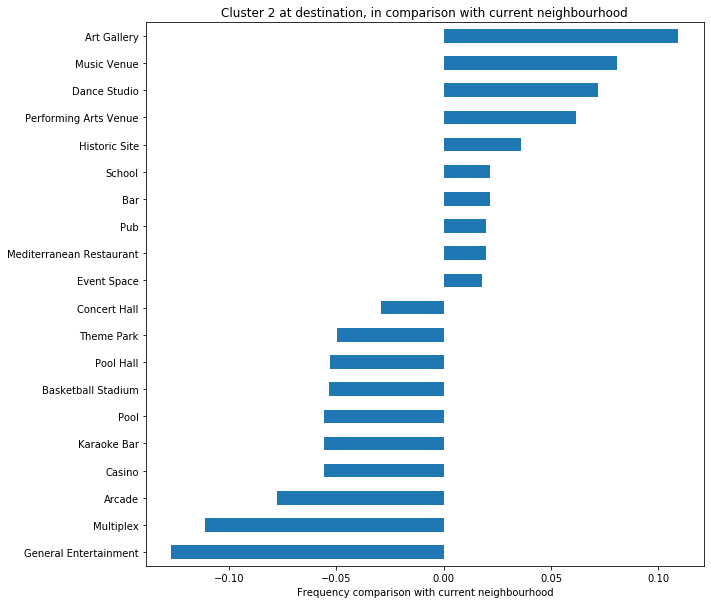

In [138]:
plotSummary(summary_2_art, 'Cluster 2 at destination, in comparison with current neighbourhood')

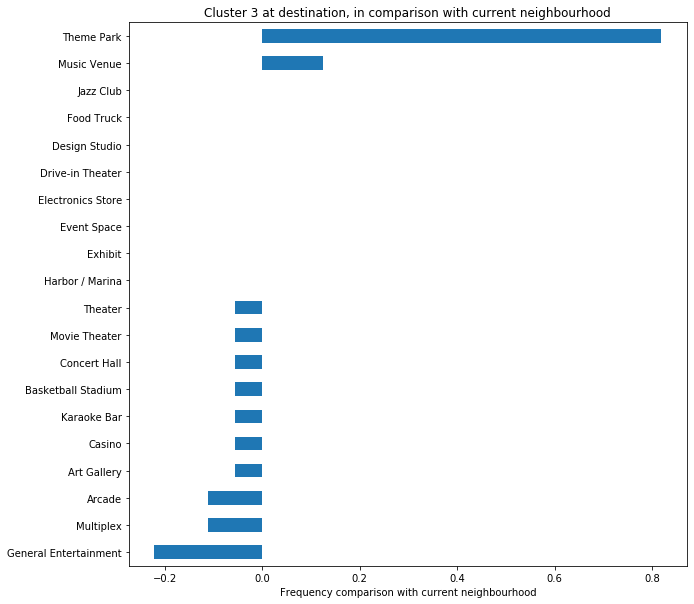

In [139]:
plotSummary(summary_3_art, 'Cluster 3 at destination, in comparison with current neighbourhood')

Observation: 

Cluster 2, which included the 'closest neighbourhood' in terms of art/entertainment shows more art and musuems but less entertainment areas than current neighbourhood.
On the contrary Cluster 0 is more oriented on the entertainment venues.

# Results and discussion

We provided an overall overview of what neighborhood in Toronto fits the best to current profile: this was identified in "Neighborhood 20"; around bloor younge station. (please refer to corresponding map above)

Clusterisation did not highlight anything specific on this aspect: there is no miracle regarding asian food, when comparing singapore and toronto.

As this overview eventually provided mostly insights on food related aspects; an extended analysis was done focusing on the art/Entertainment aspect.

As a result, it appeared here again that the toronto neighborhoods in the searched area were quite homogeneous, mostly centered around Art places. However, even in this central district, some neighborhood were really distringuishable, focusing on Entertainment.

Neighbouhood 20, which was the closest overall to current neighbourhood also to be rich in terms of art gallery and performance places, but also at walking distance to Neighbourhood 24, part of the ‘Entertainment cluster’. 


At this stage, the recommendation to the customer will therefore be Neighbourhood 20.

However, decision will be on his side, and further analyses may be requested. We can already anticipate: 
- A larger area of search, the current one is very central in Toronto, leading to some unexpected homogeneity overall.
- Possible search regarding other specific venues category.

The tool is flexible to ensure both.


# Conclusion

The objective was to provide a tool and corresponding analysis, to help customers, moving from one city to another, to identify the destination's cities neighbourhood profile, in comparison with the neighbourhood they are familiar with.
- First, I created a tool, made in a generic way, so that any area can be compared to any city.
- The notebook is also organised so that extended analyses can be easily generated, according to customer feedbacks on what aspects and what venues matter the most for him.

My analysis obviously did not react on any customer feedbacks, I therefore took the assumption of someone moving from a eastern part of Singapore to Toronto, searching in the central part of Toronto.

Toronto was chosen for me to evaluate the results of this modified approach (neighbourhood made of a grid instead of defined neighborhood) compared to previous lab, and also because it presented an additional difficulty, being close to the sea - which is taken into account in data treatment. However, the method and tool is made to be generic, and proved to work, for example on a Paris to Barcelona relocation.


Based on this analysis, there already are good insights to share with the customer. There are definitiely ways to get an even more detailed study, by looking at larger area of toronto, or filtering further the sub-categories expected by the customer. This study however demonstrate the methodology followed, and the corresponding notebook can be used by anyone to do the corresponding search expected. 


One might argue that instead of clusterising the neighbourhood we can instead create a map based on ‘distance’ with reference neighbourhood. We actually have all data needed at this stage, as the distance was calculated to determine the closest neighbourhood. I however found more interesting, as part of the coursera course, but also in terms of methodology to dress clusters; that highlight different profiles of neighbourhood that can be interpreted, while the ‘distance’ notion is quite vague.

To get more detailed analysis, it would also be interesting to gather more than 30 venues per neighbourhood, but I wanted to leave this analysis 'light' interms of resources used.


Note: foursquare API is showing some instability with request includes list of categories, you may have to try several times the corresponding entry in the notebook, but you are more than welcome to give this notebook a try, at least for the overview part.


Thank you for reading